retrieve OHLC data and calculate daily returns

In [13]:
from datetime import datetime, timedelta
from math import log
from requests import get

security = "UVXY"
precision = 4        # rounding
now = datetime.now()

def get_returns(start_days_ago, end_days_ago):
    querystring = (
                    f"https://api.tdameritrade.com/v1/marketdata/{security}/pricehistory"
                    "?apikey=NUNBJMU9XQMDAANFOT6G4MQA1I85EG7P"
                    "&periodType=month"
                    "&frequencyType=daily"
                    "&frequency=1"
                    f"&startDate={int((now - timedelta(days = start_days_ago)).timestamp() * 1000)}"
                    f"&endDate={int((now - timedelta(days = end_days_ago)).timestamp() * 1000)}"
                  )

    res = get(querystring)

    if res.status_code != 200:
        print(f"error: {res.status_code}")
        print(res.text)
        result = []

    candles = res.json()["candles"]
    
    result = [ round(log(candles[i]["close"] / candles[i - 1]["close"]), precision) for i in range(1, len(candles)) ]
    
    return result

short = get_returns(300, 0)
long = get_returns(10000, 0)

# print(returns)

generate results

cumulative density: 0.07170877379341196
method: students


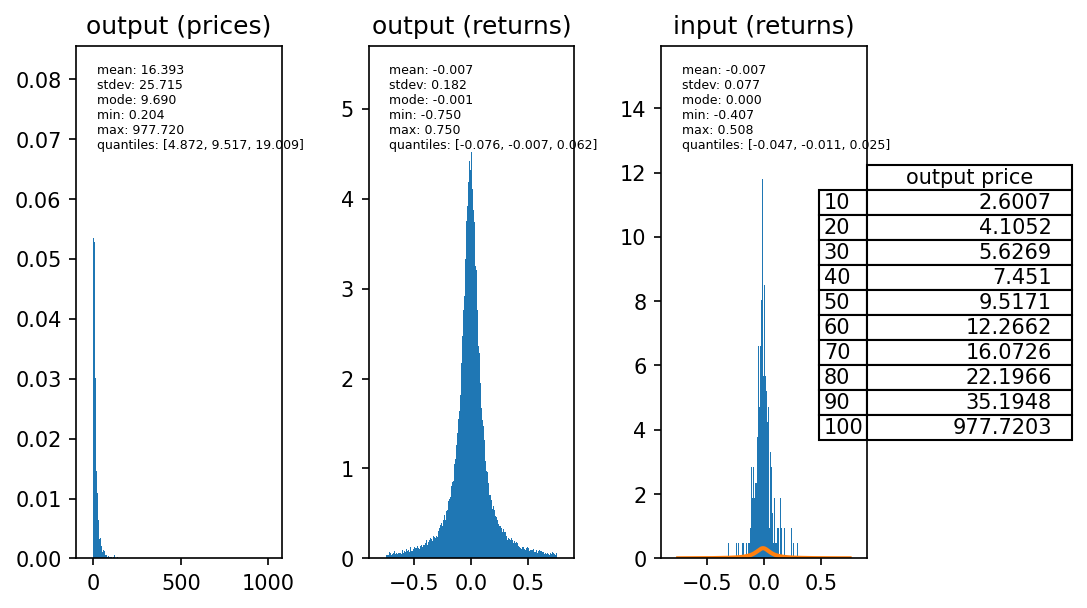

In [18]:
from statistics import fmean, stdev, mode, quantiles, NormalDist
from numpy import array, sort, percentile, linspace
from scipy.stats import t
from random import random, randint
from math import exp
from matplotlib import pyplot

# * PARAMETERS *

# security parameters
current_price = 11.77
days_to_expiration = 31

# general modeling parameters
probability_resolution = 1000  # number of probabilities to model
lim = 0.75                     # range of return domain, e.g. 0.5 = [-50%, 50%]
method = "students"

# kernel modeling parameters
smoothing = 0.05
func = "gaussian"

# student's t modeling parameters
dof = 1

# random walk parameters
trials = 10000


# * FUNCTIONS *

def get_domain(lim, probability_resolution):
    return linspace(-lim, lim, probability_resolution, retstep = True)

# the output is a set of weights, calculated from a model of x's PDF
# x: random variable to model
# domain: generate weights (densities) for the interval [ -domain, domain ]
# method:
#  - kernel: kernel density estimation
#  - simple: standard normal distribution
def model_density(x, domain, method, step):
    if method == "kernel":
        model = KernelDensity(bandwidth = smoothing, kernel = func)
        reshaped = array(x).reshape(len(x), 1)
        model.fit(reshaped)
        domain = domain.reshape(len(domain), 1)
        weights = exp(model.score_samples(domain))
    elif method == "simple":
        model = NormalDist(mu = fmean(x), sigma = stdev(x))
        weights = array([ model.pdf(point) for point in domain ])
    elif method == "students":
        model = t(dof)
        mu = fmean(x)
        sigma = stdev(x)
        weights = array([ model.pdf((point - mu) / sigma) for point in domain ])
    
    print(f"cumulative density: { sum(weights * step) }")
    
    return weights

# mean, stdev, and quantiles
def get_stats(x):
    mu = round(fmean(x), precision)
    sigma = round(stdev(x), precision)
    mod = round(mode(x), precision)
    qt = [ round(q, precision - 1) for q in quantiles(x) ]
    
    return (mu, sigma, mod, min(x), max(x), qt)

# plots a histogram of x
def display(x, title, ax, density):
    fmt_string = (
                    "mean: %.3f\n"
                    "stdev: %.3f\n"
                    "mode: %.3f\n"
                    "min: %.3f\n"
                    "max: %.3f\n"
                    "quantiles: %s"
                )
    
    ax.set_title(title)
    ax.margins(0.1, 0.25)
    text = fmt_string % get_stats(x)
    ax.text(0.1, 0.80, text, transform = ax.transAxes, size = 6)
    ax.hist(x, bins = probability_resolution, density = density)

    
def display_all(output_prices, output_returns, input_returns, domain):
    print("method: %s" % method)

    #pyplot.subplots_adjust(wspace = 0.25)

    fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, dpi = 150)
    fig.tight_layout()

    # table of percentiles for output prices
    output_prices = sort(output_prices)
    rows = [ i for i in range(10, 101, 10) ]
    cols = [ "output price" ]
    text = [ [ round(p, precision) ] for p in percentile(output_prices, rows) ]
    pyplot.table(cellText = text, rowLabels = rows, colLabels = cols, loc = "right")

    # output, prices
    display(output_prices, "output (prices)", ax1, True)

    # output, log daily returns
    reshaped = array(output_returns).reshape(len(output_returns[0]) * len(output_returns))
    display(reshaped, "output (returns)", ax2, True)

    # input, log daily returns, and model
    display(input_returns, "input (returns)", ax3, True)
    ax3.plot(domain, weights, linewidth = 2)

    pyplot.show()

# generates a set of random variables (samples) according to a given pdf; a set of random walks
# domain: the population domain
# weights: the density of each member of the population domain--weights[i] is the probability of x[i]
def get_samples(domain, weights, sample_length, num_samples):
    samples = []
    
    for i in range(num_samples):
        x = []
        while(len(x) < sample_length):
            i = randint(0, len(weights) - 1)
            p = weights[i]
            if (random() < p):
                x.append(domain[i])
        samples.append(x)
                              
    return samples
    
# applies random walks from the get_samples function to a start point
def walk(start, samples, length, count):
    results = []

    for sample in samples:
        result = start
        for i in sample:
            result *= exp(i)
        results.append(result)
        
    return results

# * PROGRAM *

x = long

domain, step = get_domain(lim, probability_resolution)
weights = model_density(x, domain, method, step)
output_returns = get_samples(domain, weights, days_to_expiration, trials)
output_prices = walk(current_price, output_returns, days_to_expiration, trials)
display_all(output_prices, output_returns, x, domain)